In [141]:
import numpy as np
import matplotlib.pyplot as plt

from optimizer import GradientOptimizer
from util import compare_methods, solution_visualization
from test_functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [143]:
initial_point = np.array([-0.5, 2.0])

optimizer = GradientOptimizer(
    function=Rosenbrock_function,
    grad_function=Rosenbrock_gradient,
    initial_point=initial_point,
    method="Adam",
)

x_seq, y_seq = optimizer.find_minimum()

In [126]:
alphas = np.linspace(0.1, 0.01, 10)
betas_1 = np.linspace(0, 1, 10)
betas_2 = np.linspace(0, 1, 10)

optimizer.hyperparameter_optimization(alphas, betas_1, betas_2)
print(optimizer.alpha, optimizer.beta_1, optimizer.beta_2)

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

0.03 0.8888888888888888 0.6666666666666666


In [127]:
adam_default = GradientOptimizer(
    function=Rosenbrock_function,
    grad_function=Rosenbrock_gradient,
    initial_point=initial_point,
    method="Adam",
)

In [ ]:
x_seq, y_seq = adam_default.find_minimum()

xlim = (-1.5, 2)
ylim = (-0.5, 3)
x_star = np.array([1, 1])

cmap = "magma_r"

solution_visualization(
    function=Rosenbrock_function,
    x_seqs=[x_seq],
    labels=["Adam"],
    xlim=xlim,
    ylim=ylim,
    step=0.05,
    x_star=x_star,
    cmap=cmap,
    animate=False,
)

In [147]:
np.nan < 1

False

100%|██████████| 10/10 [00:00<00:00, 190.45it/s]


GD: steps = 500, value = 24.69938772511399, lr = 0.09, beta_1 = 0.9, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 17.10it/s]


Momentum: steps = 500, value = 9.474751644569182, lr = 0.03, beta_1 = 0.30000000000000004, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 11.17it/s]


NesterovMomentum: steps = 500, value = 5.203559220034368, lr = 0.01999999999999999, beta_1 = 0.30000000000000004, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 13.02it/s]


RMSProp: steps = 500, value = 13.139665453475397, lr = 0.09, beta_1 = 0.9, beta_2 = 0.0


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Adam: steps = 500, value = 0.9949590570932934, lr = 0.07, beta_1 = 0.9, beta_2 = 1.0


100%|██████████| 10/10 [00:00<00:00, 594.34it/s]


GD: steps = 500, value = nan, lr = 0.1, beta_1 = 0.9, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 24.93it/s]


Momentum: steps = 500, value = nan, lr = 0.1, beta_1 = 0.0, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 18.02it/s]


NesterovMomentum: steps = 500, value = nan, lr = 0.1, beta_1 = 0.0, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 18.20it/s]


RMSProp: steps = 500, value = 2.888274772094246, lr = 0.01, beta_1 = 0.9, beta_2 = 0.7000000000000001


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Adam: steps = 500, value = 0.005780150622915067, lr = 0.03, beta_1 = 0.9, beta_2 = 0.7000000000000001


100%|██████████| 10/10 [00:00<00:00, 476.73it/s]


GD: steps = 500, value = 0.004866054150648176, lr = 0.1, beta_1 = 0.9, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 24.01it/s]


Momentum: steps = 500, value = 0.0011492706393241461, lr = 0.1, beta_1 = 0.9, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 18.07it/s]


NesterovMomentum: steps = 500, value = 0.00010468318072477662, lr = 0.1, beta_1 = 1.0, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 16.81it/s]


RMSProp: steps = 500, value = 0.0001867822328682995, lr = 0.01999999999999999, beta_1 = 0.9, beta_2 = 0.8


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Adam: steps = 500, value = 9.68630501643775e-08, lr = 0.01999999999999999, beta_1 = 0.9, beta_2 = 0.8


100%|██████████| 10/10 [00:00<00:00, 333.88it/s]


GD: steps = 500, value = 3.0755798054028054e-96, lr = 0.1, beta_1 = 0.9, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 25.83it/s]


Momentum: steps = 500, value = 3.1873730903619018e-220, lr = 0.1, beta_1 = 0.30000000000000004, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 24.07it/s]


NesterovMomentum: steps = 500, value = 6.535540717222393e-246, lr = 0.1, beta_1 = 0.4, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 20.75it/s]


RMSProp: steps = 500, value = 3.075583642190899e-96, lr = 0.1, beta_1 = 0.9, beta_2 = 1.0


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Adam: steps = 500, value = 3.8674813248906933e-149, lr = 0.1, beta_1 = 0.5, beta_2 = 1.0


100%|██████████| 10/10 [00:00<00:00, 492.94it/s]


GD: steps = 500, value = 1.9683710754577956e-96, lr = 0.1, beta_1 = 0.9, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 30.55it/s]


Momentum: steps = 500, value = 2.039918777831657e-220, lr = 0.1, beta_1 = 0.30000000000000004, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 20.57it/s]


NesterovMomentum: steps = 500, value = 4.182746059022334e-246, lr = 0.1, beta_1 = 0.4, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 20.16it/s]


RMSProp: steps = 500, value = 1.96837353100218e-96, lr = 0.1, beta_1 = 0.9, beta_2 = 1.0


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Adam: steps = 500, value = 2.4889352957963597e-149, lr = 0.1, beta_1 = 0.5, beta_2 = 1.0


100%|██████████| 10/10 [00:00<00:00, 511.36it/s]


GD: steps = 500, value = 0.0, lr = 0.09, beta_1 = 0.9, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 23.06it/s]


Momentum: steps = 500, value = 0.0, lr = 0.1, beta_1 = 0.1, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 16.68it/s]


NesterovMomentum: steps = 500, value = 0.0, lr = 0.09, beta_1 = 0.0, beta_2 = 0.99


100%|██████████| 10/10 [00:00<00:00, 17.65it/s]


RMSProp: steps = 500, value = 0.0, lr = 0.09, beta_1 = 0.9, beta_2 = 1.0


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Adam: steps = 500, value = 0.0, lr = 0.1, beta_1 = 0.1, beta_2 = 1.0


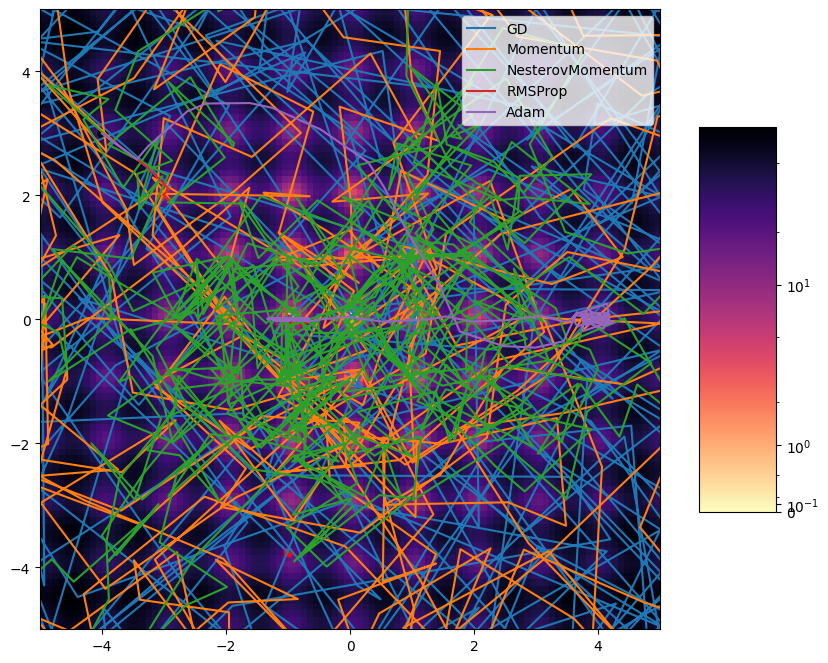

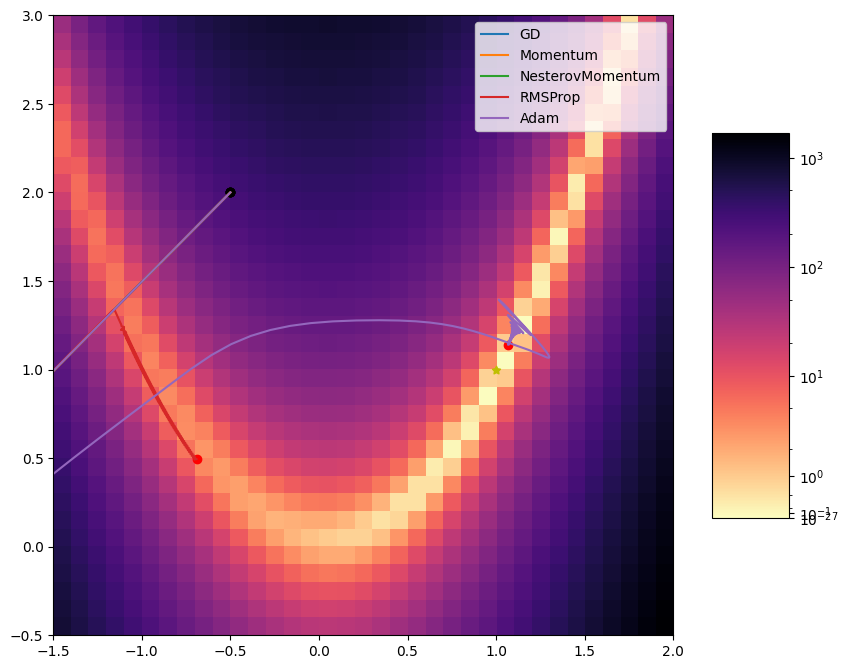

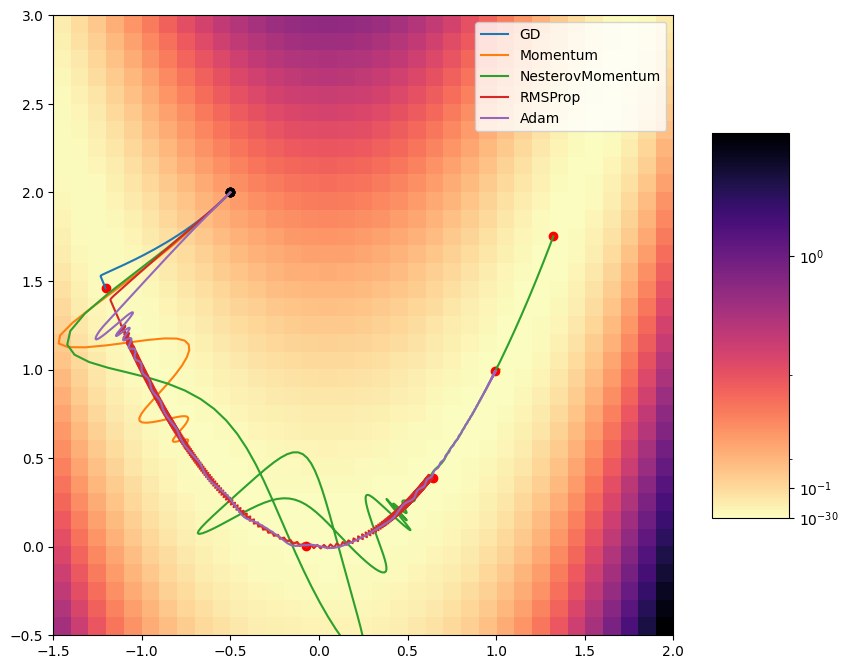

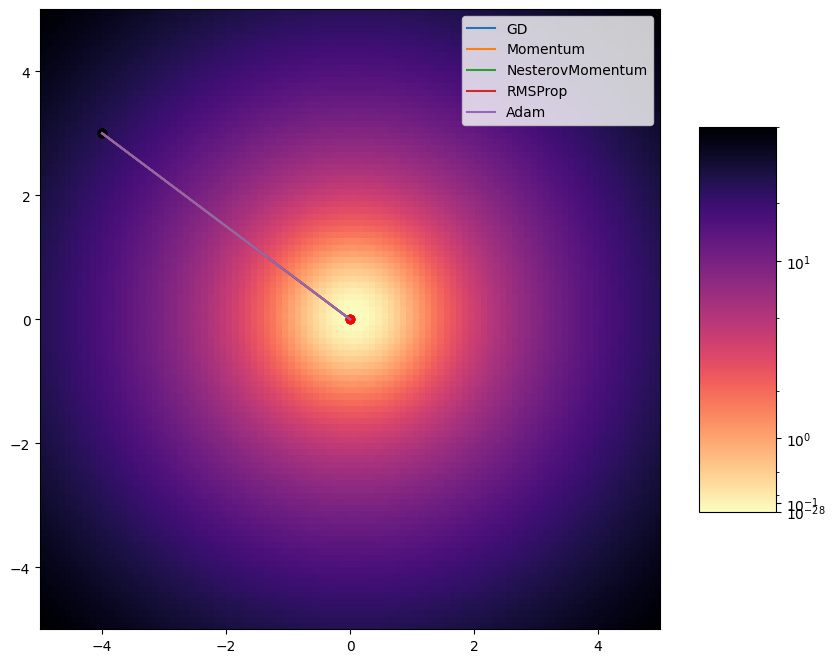

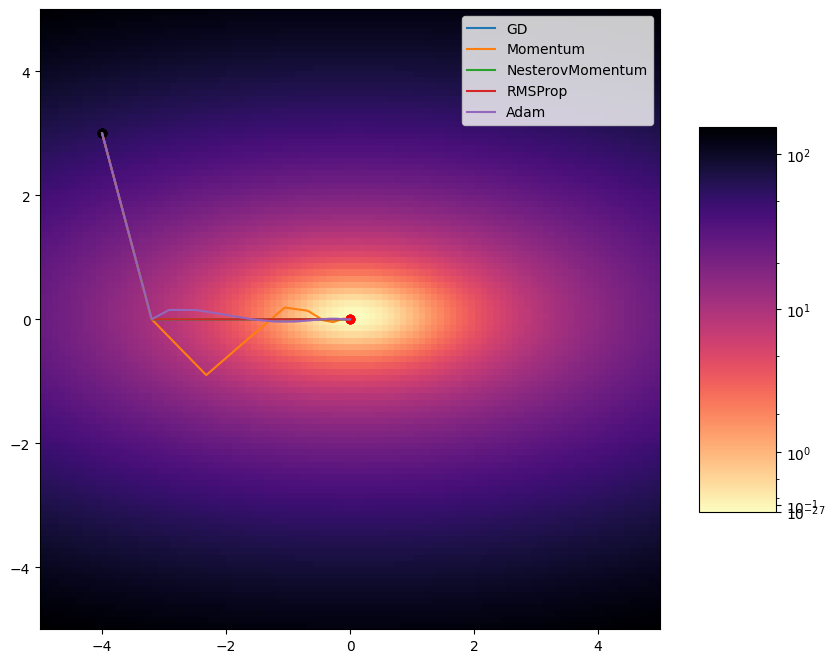

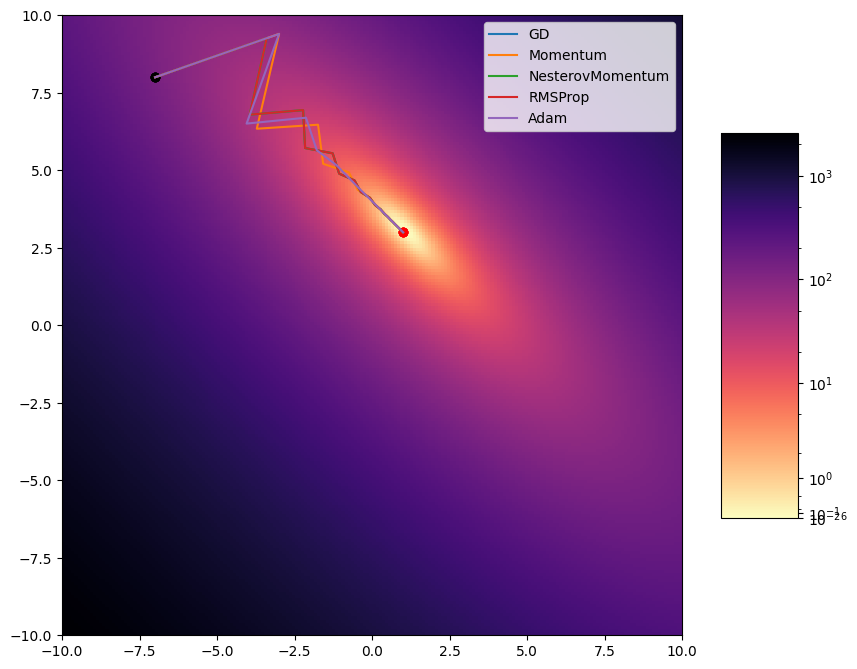

In [148]:
initial_points = [
    np.array([-4, 3]),
    np.array([-0.5, 2.0]),
    np.array([-0.5, 2.0]),
    np.array([-4, 3]),
    np.array([-4, 3]),
    np.array([-7, -8]),
]

xlims = [
    (-5, 5),
    (-1.5, 2),
    (-1.5, 2),
    (-5, 5),
    (-5, 5),
    (-10, 10),
]

ylims = [
    (-5, 5),
    (-0.5, 3),
    (-0.5, 3),
    (-5, 5),
    (-5, 5),
    (-10, 10),
]

x_stars = [
    np.array([0, 0]),
    np.array([1, 1]),
    np.array([1, 1]),
    np.array([0, 0]),
    np.array([0, 0]),
    np.array([1, 3]),
]

functions = [
    Rastrigin_function,
    Rosenbrock_function,
    normalized_Rosenbrock_function,
    sphere_function,
    ellipse_function,
    Booths_function,
]

grad_functions = [
    Rastrigin_gradient,
    Rosenbrock_gradient,
    normalized_Rosenbrock_gradient,
    sphere_gradient,
    ellipse_gradient,
    Booths_gradient,
]

for i in range(len(functions)):
    compare_methods(
        function=functions[i],
        grad_function=grad_functions[i],
        initial_point=initial_points[i],
        xlim=xlims[i],
        ylim=ylims[i],
        x_star=x_stars[i],
    )